In [30]:
import pandas as pd
import numpy as np
import pylab as pl
import os 
import datetime
import time
import re
import xlsxwriter
import math as mt
from math import sqrt
from matplotlib.pyplot import *

from sklearn.metrics import mean_squared_error

%matplotlib inline
#%matplotlib notebook
from itertools import product
from time import sleep


import seaborn as sns
#from statsmodels import  tsa.stattools
#import statsmodels.tsa.stattools.acf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_model import ARIMA

from sklearn.datasets import load_iris
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
# Though the following import is not directly being used, it is required
# for 3D projection to work
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import load_iris

from sklearn.neighbors import KNeighborsClassifier

from sklearn.cluster import KMeans
from sklearn import datasets
os.chdir(r'E:\Work\RStudio\WD\V5GJBsupport\JuceNet')
import pytz




In [31]:
os.getcwd()

'E:\\Work\\RStudio\\WD\\V5GJBsupport\\JuceNet'

In [2]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)

Windows-7-6.1.7601-SP1
Python 3.6.0 |Anaconda 4.3.0 (64-bit)| (default, Dec 23 2016, 11:57:41) [MSC v.1900 64 bit (AMD64)]
NumPy 1.13.1
SciPy 1.0.1
Scikit-Learn 0.19.0


In [6]:

class JNmodel:
    
#class analysis(JNmodel):
    
    def preliminary_analysis(self, df):
        result = df.EventString.value_counts()
        shape = df.shape
        dtype = df.dtypes
        print('event count: \n', result, '\n')
        print('df size is:  \n', shape, '\n')
        print('types of the columns are:  \n',dtype, '\n')
        
    def All_possible_patterns_count(self, df):
        unitid_event_string = df.loc[:,['UnitID', 'EventString']].copy()
        #one = df.loc[:,'EventString'].copy()
        unitid_event_string['Shifted_EventString'] = df.EventString.shift(periods = -1)
        count_different_patterns = unitid_event_string.groupby(['UnitID','EventString','Shifted_EventString']).agg({'Shifted_EventString':'count'})
        return(count_different_patterns)
        

    def bad_data_analysis(self, df):
        # Bed data row removal:
        print('the bad data will look like this: \n',  df.loc[df.PartitionKey != df.UnitID,:].head(n=2))
        value1 = df.loc[df['RowKey'].str.contains('Char', regex=True) == True,'RowKey'].shape[0]
        value2 = len(df.loc[(df.PartitionKey != df.UnitID) & (df['RowKey'].str.match('Charg') == True),:])
        value3 = len(df.loc[(df.PartitionKey != df.UnitID) & (df['RowKey'].str.match('Off') == True),:])
        value4 = len(df.loc[(df.PartitionKey != df.UnitID) & (df['RowKey'].str.match('On') == True),:])
        value5 = len(df.loc[(df.PartitionKey != df.UnitID) & (df['RowKey'].str.match('Plug') == True),:])
        total  = sum([value2,value3,value4,value5])
        value6 = len(df.loc[(df.PartitionKey != df.UnitID),:])
        final_table = pd.DataFrame([value1, value2, value3, value4, value5,total, value6] , index = ['Row_Key_Char','Charg','Off','On','Plug','sum','totlal' ])
        print(final_table)
        
 
        dft = dft.loc[dft.state == 'CA',:].copy()
        return(dft)
    


class tools(JNmodel):
    def __init__(self, filename):
        #self.path = path
        self.filename = filename
        #os.chdir('r\''+self.path)
        
# used with  my_read_csv   
    def make_serie_as_datetimein_PST_time(self, serie):
        serie = pd.to_datetime(serie)
        serie = serie.tz_localize('UTC').tz_convert('US/Pacific-New')
        return(serie)
    
    def my_read_csv(self, serie):
        #print(self.pp())
        resulting_csv = pd.read_csv(self.filename,  date_parser = self.make_serie_as_datetimein_PST_time, parse_dates = ['index'] )

        return(resulting_csv)  
    
# substitute all date for one day 1/1/2018, keeping time valid 
    def make_one_date_date(self,dd,columname, columoutput="One_day" ):
        df= dd.copy()
        #temp  = df.loc[(df.EventString == 'PlugIn'), ['Time','UnitID']].copy()
        temp = pd.to_datetime('1/1/2018' + ' ' + df[columname].dt.time.astype('str'))
        df[columoutput] = temp
        return(df)

# introduce catecorical variable for mentioned string column   
    def make_df_faster(self, dd, categorial_string_list):
        df = dd.copy()
        print('\nOriginal Memory usage:\n', df.memory_usage(deep= True))
        df[categorial_string_list] = df[categorial_string_list].astype('category')
        print('\nMemory usage after categorising all string columns:\n', df.memory_usage(deep= True))
        return(df)
#     
    def end_and_start_time_differance_delta(self, dd, EventString, end_time, start_time, time_column):
        df = dd.loc[(dd[EventString] == end_time) | (dd[EventString] == start_time), [EventString,time_column]].copy()
        df['Shifted_Time'] = df[time_column].shift(periods = -1)
        df['Shifted_EventString'] = df[EventString].shift(periods = -1)
        df.drop(df.index[-1], axis =0, inplace =True)
        df = df.loc[df[EventString ]  == start_time ,:].copy() 
        df['delta'] = (df.Shifted_Time - df[time_column])
        df['delta'] = df.delta.dt.seconds/3600
        
        return(df)
    
    def charing_time() :
        pass
        
class JNLoadModel(JNmodel):
    
    def create_range_whith_realstart_end(self,start, end, freq):
        start_rounded = start.ceil('5min')
        end_rounded = end.floor('5min')

        dft = pd.date_range(start_rounded, end_rounded , freq=freq)#.floor('5min')

        dft = dft.insert(0, pd.Timestamp(start.round('s'), tz = 'US/Pacific-New'))
        dft = dft.insert(len(dft)+1, pd.Timestamp(end.round('s'), tz = 'US/Pacific-New'))
        dft = dft.sort_values()
        return(dft)

    def create_range_whith_rounded_end(self,start, end, freq):
        start_rounded = start.ceil('5min')
        end_rounded = end.floor('5min')
        delta1 = start_rounded - start
        delta2  =end -end_rounded
        dft = pd.date_range(start_rounded, end_rounded , freq=freq)#.floor('5min')
        dft = dft.sort_values()
        return(dft, delta1, delta2)

    def create_solid_dataframe(temp):
        seri = create_range_whith_realstart_end(temp.Time[0],temp.Shifted_Time[0],'5min')
        value = temp.Power_Value[temp.index[0]]
        seri = seri.sort_values()

        result = pd.DataFrame({'Power': value, 'UnitID':temp.UnitID[temp.index[0]], 'Status': 'ChargingStart'}, index = seri)
        result.reset_index(inplace = True)
        plug_in_out['Power'] = 0
        plug_in_out.columns = ['index','UnitID','Status','Power']

        plug_in_out.iloc[0,0] =  plugIn_index[plugIn_index.index[0]] - pd.Timedelta('1 second')

        frames = [result, plug_in_out]

        result = pd.concat(frames)
        result.set_index('index',inplace = True)

        result = result.sort_index()
        return(result)

    def par(dd):
        df = dd.copy()
        df['Time'] = df.Time.dt.round('s')
        grp  = df.groupby('snum',group_keys=True)

        ft = pd.DataFrame()
        for k, v in grp:
                temp = grp.get_group(k).sort_values('Time', ascending=True)

                plug_in_out = temp.loc[(temp.EventString == 'PlugIn') | (temp.EventString == 'PlugOut'),['Time','UnitID','EventString']].copy()
                plugIn_index = temp.loc[(temp.EventString == 'PlugIn'),'Time'].copy()
                plugOut_index = temp.loc[(temp.EventString == 'PlugOut'),'Time'].copy()

                temp = temp.loc[(temp.EventString == 'ChargingStart') | (temp.EventString == 'ChargingStop'), ['Time','snum','EventString','EventEnergy','UnitID']].copy()   
                #print(temp)
                temp['Shifted_Time'] = temp.Time.shift(periods = -1)

                temp['Shifted_EventString'] = temp.EventString.shift(periods = -1)

                temp['Shifted_EventEnergy'] = temp.EventEnergy.shift(periods = -1)
                temp.drop(temp.index[-1], axis =0, inplace =True)

                temp = temp.loc[temp.EventString   == 'ChargingStart',:].copy() 

                temp['delta'] = (temp.Shifted_Time - temp.Time)
                temp['delta'] = temp.delta.dt.seconds/3600
                temp['Shifted_EventEnergy'] = temp.Shifted_EventEnergy/1000

                temp['Power_Value'] = temp.Shifted_EventEnergy/temp.delta
                print(temp)
                df_result = pd.DataFrame()
                fr = pd.DataFrame()
                for row in temp.iterrows():
                    seri,delta1,delta2 = create_range_whith_rounded_end(self,row[1].Time,row[1].Shifted_Time,'5min')
                    #seri, delta1,delta2 = create_range_whith_realstart_end(row[1].Time,row[1].Shifted_Time,'5min')

                    value = row[1].Power_Value
   
                    seri = seri.sort_values()

                    result = pd.DataFrame({'Power': value, 'UnitID':row[1].UnitID, 'Status': 'ChargingStart'}, index = seri)
                    result.reset_index(inplace = True)

                    df_result = pd.concat([df_result, result])
                plug_in_out['Power'] = 0
                plug_in_out.columns = ['index','UnitID','Status','Power']

                plug_in_out.iloc[0,0] =  plugIn_index[plugIn_index.index[0]] - pd.Timedelta('1 second')

                result_fr = pd.concat([df_result, plug_in_out])

                result_fr.set_index('index',inplace = True)

                result_fr = result_fr.sort_index()
                ft = pd.concat([ft, result_fr])
                #k =k+1
                #print(k)
        return(ft)
# the result of this run is load_model_3months_better.csv having all
# load data for every 5 min interval during 24 hours for every Unit


    
class Cleaningdata(JNmodel):
    
    
    def get_rid_of_emulators(self, df):
        df = df.iloc[:,1:11]
        # Getting rid off emulators starting with 3737
        amount_of_unique_emulators = len(df.loc[df['UnitID'].str.match('3737') == True,'UnitID'].unique())
        print("amount of unique emulators is: ", amount_of_unique_emulators )
        df = df.loc[df.UnitID.str.match('3737') != True, :]
        print('amount of unique rows is:' , df.shape)
        return(df)
    
    
    def bad_data_removal(self, df):
        # Bed data row removal:
        df = df.loc[(df.PartitionKey == df.UnitID),:].copy()
        #df = self.get_rid_of_emulators(self, df)
        print(df.shape)
        return(df)
    
   
    def adding_extra_columns(self, df):
        # Adding time, time stamp
        df['Time'] = pd.to_datetime(df.Timestamp)
        df['Time'] = df.Time.dt.tz_localize('UTC').dt.tz_convert('US/Pacific-New')   
        df['dt_ts'] = df.loc[:,'Time'].astype('int64')//1e9
        df = df.iloc[:,1:12]
        # Assinging categorical variable for Event string to make plots
        df['event_bolen']= df.EventString.map({'Offline':0, 'Online':1, 'PlugIn':2, 'ChargingStart':3, 'ChargingStop':4,
       'PlugOut':5})
        df['snum'] = 0
        df['UnitID'] = df['UnitID'].astype(str)
        df['WeekDay'] =  df.Time.dt.weekday
        return(df)
    
    
    def CA_Unit_id(self, unit_zip, zip_state, df):
        zip_state =zip_state.loc[:,:].copy()
        unit_zip =unit_zip.loc[:5186,:].copy()

        zip_state['zip'] = zip_state.zip.astype('str')
        unit_zip.set_index('ZipCode', inplace =True, drop= False)

        gg  = pd.merge(unit_zip, zip_state, how = 'inner', left_on = 'ZipCode', right_on = 'zip' )
        result = gg.drop_duplicates(keep='first')
        dft = pd.merge(df, result.loc[:,['UnitID','state']].copy(), how = 'left', on = 'UnitID' )
        return (dft.loc[dft.state =='CA',:].copy())

    def data_cleaning(self, unit_zip, zip_state, df):
        df  = self.get_rid_of_emulators(self, df)
        df =  self.bad_data_removal(self, df)
        df  = self.adding_extra_columns(self, df)

        #df  = self.CA_Unit_id(self, unit_zip, zip_state, df)
        #print(df)
        return(df)
    
class creating_final_table(JNmodel):

# Finding the rows based on right charging patterns        
    def find_row_corresponding_to_partern(self, dd, colname,snum):
        df =dd.copy()
        partert_to_match_to = r"(2(?:34){1,12}5)" # ?: ignores adding the group; r"(2(?:343434343434){1,12}5)"
        resulting_df = pd.DataFrame()
        df.reset_index(inplace=True)
        string_series = df.loc[:,colname].astype('str').str.cat(sep='')
        patern_position = []

        for m in re.finditer(partert_to_match_to, string_series):
            temp = np.arange(m.start(),m.end())
            snum = snum +1
            df.loc[temp,'snum'] = snum
            frames = [resulting_df,df.loc[temp]]
            #print(snum,df.loc[temp])
            resulting_df = pd.concat(frames)
            #print(resulting_df)
        return(resulting_df,snum)

    def get_rows_for_resource_based_on_patern(self, df,column,snum = 0):
        frames = []
        result = pd.DataFrame()
        grp = df.groupby(['UnitID'],group_keys=True) 
        group_revenue=0
        for k,v in grp:
            temp = grp.get_group(k).sort_values('Time', ascending=True)
            temp_df, snum = self.find_row_corresponding_to_partern(self,temp, column,snum)
            #print(temp_df)
            #print(temp_df['snum']= snum)
            frames = [result,temp_df]
            #print(temp_df)
            result = pd.concat(frames)
            
        #print('result',result )
        result.set_index('index', inplace=True)
        #print('print', result)
        return(result)

    
class smart_data_cleaning(JNmodel):    
                                        # Detailed analytics with data removal. 
        
# Delete session with large power, more that 10kw.

    def corrected_power_value(self, df):
        #df.set_index('index', inplace = True)
        # get rid of sessions with power more than 10Kw
        group_session = df.loc[df.EventString == 'ChargingStop', ['UnitID', 'EventString','snum','EventDuration','EventEnergy','power']].groupby(['snum']).agg({'EventDuration' :'sum','EventEnergy':'sum'})
        group_session['result'] = (group_session.EventEnergy/1000)/(group_session.EventDuration/3600)
        gg = group_session.loc[group_session.result > 10,:].index.tolist()
        return(df.loc[-df.snum.isin(gg),:].copy())
    
# getting rid of sessions where charign time is not equal to sum of event duration:
   
    def total_charing_time_equal_of_charingStopEventduartion(self, df):
        EventDuration = df.loc[df.EventString =='ChargingStop', :].groupby(['snum']).agg({'EventDuration':'sum'})
        totlal_ChargingTime = df.loc[df.EventString =='ChargingStop', :].groupby(['snum']).agg({'ChargingTime':'max'})
  
        duration_sum_check = pd.DataFrame({'EventDuration':EventDuration.EventDuration,'ChargingTime':totlal_ChargingTime.ChargingTime })
        print(duration_sum_check.head(n=10))

        E1 = duration_sum_check.loc[duration_sum_check.EventDuration == duration_sum_check.ChargingTime,:]
        E2 = duration_sum_check.loc[duration_sum_check.EventDuration != duration_sum_check.ChargingTime,:]

        df_with_correct_sessions = df.loc[df.snum.isin(E1.index.get_values()) == True,:].copy()
        df_with_wrong_sessions = df.loc[df.snum.isin(E2.index.get_values()) == True,:].copy()
        return(E2.index.get_values(), df_with_correct_sessions, df_with_wrong_sessions)
    

# getting rid of sessions with abnormal enery values.
    
    def total_energy_equal_to_sum_of_charingStopEnergy(self, df):
        chagrinstop = df.loc[df.EventString =='ChargingStop', :].groupby(['snum']).agg({'EventEnergy':'sum'})
        totlal_energy = df.loc[df.EventString =='ChargingStop', :].groupby(['snum']).agg({'TotalEnergy':'max'})
        print(chagrinstop.head(n=5),'\n\n',totlal_energy.head(n=5))
        energy_sum_check = pd.DataFrame({'charing_stop':chagrinstop.EventEnergy,'total_energy':totlal_energy.TotalEnergy })
        E1 = energy_sum_check.loc[energy_sum_check.charing_stop==energy_sum_check.total_energy,:]
        E2 = energy_sum_check.loc[energy_sum_check.charing_stop!=energy_sum_check.total_energy,:]
        print('number of sesions with total energy equal to sum of charing energy:\n', E1.shape)
        print('number of sesions with total energy not equal to sum of charing energy:\n', E2.shape)

        df_with_correct_sessions = df.loc[df.snum.isin(E1.index.get_values()) == True,:].copy()
        df_with_wrong_sessions = df.loc[df.snum.isin(E2.index.get_values()) == True,:].copy()
        #new_df = df.loc[-df.snum.isna(E2.index)]
        return(energy_sum_check.head(n=5),E2.index.get_values() ,df_with_correct_sessions,df_with_wrong_sessions)

# Getting rid of sessions where Event duation for plug_out is equal delta df.time

    def total_time_equal_to_TotalDration(self, df):
        print('\n\n\n AAAAAAAAAAAAAA','\n\n\n' ,df.head(n=2))
        #df.reset_index(inplace=True)
        df.set_index('snum', inplace=True)
        PluginTime = df.loc[df.EventString == 'PlugIn', 'Time'].copy()
        PlugOutTime = df.loc[df.EventString == 'PlugOut', 'Time'].copy()
        print('\n\n\n BBBBBBB','\n\n\n' ,df.head(n=2))
        
        #print(PluginTime.head(n=2),PluginTime.dtypes)
        #print(PluginTime.head(n=2),  PlugOutTime.dtypes)

        delta_df = pd.concat([PluginTime,PlugOutTime], axis = 1)
        delta_df.columns = ['PluginTime','PlugOutTime']
        
        #print(delta_df.head(n=3))
        
        delta_df['delta'] = delta_df.PlugOutTime - delta_df.PluginTime
        delta_df['delta'] = delta_df.delta.dt.seconds 

        # Plugged sessions duration
        Event_Duration_plug_in = df.loc[df.EventString == 'PlugOut', 'EventDuration'].copy()

        delta_df = pd.concat([delta_df, Event_Duration_plug_in ], axis=1)
        df.reset_index(inplace=True)
        df.set_index('index', inplace=True)

        E1  = delta_df.loc[(delta_df.delta - delta_df.EventDuration) < 1,:].copy()
        E2  = delta_df.loc[(delta_df.delta - delta_df.EventDuration) > 1,:].copy()
        
        df_with_correct_timing = df.loc[df.snum.isin(E1.index.get_values()) == True,:].copy()
        df_with_wrong_timing = df.loc[df.snum.isin(E2.index.get_values()) == True,:].copy()
        return(df_with_correct_timing, df_with_correct_timing.shape )
        
    def more_data_removal(self, df):
        df = self.corrected_power_value(self, df)
        index, correct_df, wrong_df = self.total_charing_time_equal_of_charingStopEventduartion(self, df)
        energy_sum_check, index, correct_df, wrong_df = self.total_energy_equal_to_sum_of_charingStopEnergy(self, correct_df)
        correct_df, correct_df_shape = self.total_time_equal_to_TotalDration(self, correct_df)
        
       
        return(correct_df)
    
    
class JN_model_analytics:
    
    def make_one_date_date(self,series):
        #temp  = df.loc[(df.EventString == 'PlugIn'), ['Time','UnitID']].copy()
        temp = pd.to_datetime('1/1/2018' + ' ' + series.dt.time.astype('str'))
        return(temp)
        
    
    def plug_in_out_plot(self, df):
        temp  = df.loc[(df.EventString == 'PlugIn'), ['Time','UnitID']].copy()
        temp['day_index'] = pd.to_datetime('1/1/2018' + ' ' + df.Time.dt.time.astype('str'))
        print(temp.shape)
        
        temp1  = df.loc[(df.EventString == 'PlugOut'), ['Time','UnitID']].copy()
        temp1['day_index'] = pd.to_datetime('1/1/2018' + ' ' + df.Time.dt.time.astype('str'))
        print(temp1.shape)
        
        PlugIn =temp.day_index
        PlugOut = temp1.day_index
        
        aa  =  pd.to_timedelta(a).astype('timedelta64[s]')
        bb  = pd.to_timedelta(b).astype('timedelta64[s]')
        plt.figure(figsize=(15,15))

        plt.xlabel('PlugIn', fontsize=18)
        plt.ylabel('PlugOut', fontsize=16)
        plt.hist2d(aa, bb, (96,96), cmap=plt.cm.jet)
        plt.colorbar()


        return(PlugIn,PlugOut)


    def plug_in_distribution(self, df):
        
        temp  = df.loc[(df.EventString == 'PlugIn'), ['Time','UnitID','WeekDay']].copy()
        temp['day_index'] = pd.to_datetime('1/1/2018' + ' ' + df.Time.dt.time.astype('str'))
        temp['day_index_norm'] = temp.day_index - temp.day_index.dt.normalize()
        temp.reset_index(inplace =True)
        temp.set_index('day_index', inplace =True)
        rr = temp.UnitID.resample('10t').count()
        rr_sum = sum(rr)
        rr2 = rr/rr_sum
        print( rr2.resample('20t').sum().plot())
        return(rr2)
        
    def plug_out_distribution(self, df):
        temp  = df.loc[(df.EventString == 'PlugOut'), ['Time','UnitID','WeekDay']].copy()
        temp['day_index'] = pd.to_datetime('1/1/2018' + ' ' + df.Time.dt.time.astype('str'))
        temp['day_index_norm'] = temp.day_index - temp.day_index.dt.normalize()
        temp.reset_index(inplace =True)
        temp.set_index('day_index', inplace =True)
        rr = temp.UnitID.resample('10t').count()
        rr_sum = sum(rr)
        rr2 = rr/rr_sum
        print( rr2.resample('20t').sum().plot())#.count().plot())
        return(rr2)

    def energy_pre_seesion_distribution(self, dd):
        df = dd.loc[:,:].copy()  
        df['EventEnergy'] = df.EventEnergy/1000
        #df = df.loc[(df.EventEnergy > 0) & (df.EventEnergy < 60) , :].copy()
        group = df.groupby(['UnitID','snum']).agg({'EventEnergy':'sum' })
        group = group.loc[(group.EventEnergy >0) & (group.EventEnergy < 60), :].copy()
        print ('\n mean:',np.mean(group.EventEnergy), '\n std:',np.std(group.EventEnergy))
       
        n, bins, patches = plt.hist(group.EventEnergy, 100, normed=1, facecolor='green', alpha=0.75)
        #print(group)
        #a = np.hstack((rng.normal(size=1000),             rng.normal(loc=5, scale=2, size=1000)))
        #print(group.EventEnergy.plot.hist(bins=2000), range = (0,100))
        return(pd.Series(n), pd.Series(bins) )
    
    def plugged_time_pre_seesion_distribution(df):
        PlugIn = df.loc[(df.EventString == 'PlugIn'), ['snum','UnitID','Time']].copy()
        PlugOut  = df.loc[(df.EventString == 'PlugOut'), ['snum','UnitID','Time']].copy()
        PlugIn.set_index('snum', inplace = True )
        PlugOut.set_index('snum', inplace = True )
        
        result = PlugIn
        result 
        result['PlugOut'] =  PlugOut.Time
        result['Delta']  =  (result.PlugOut - result.Time)
        result['Delta'] = result.Delta.dt.seconds/3600
        
        n, bins, patches = plt.hist(result.Delta, 100, normed=1, facecolor='green', alpha=0.75)
                
        return(pd.Series(n), pd.Series(bins) )
             
    def plug_in_time(self, df):
        temp  = df.loc[(df.EventString == 'PlugIn'), ['Time','UnitID']].copy()
        temp['day_index'] = pd.to_datetime('1/1/2018' + ' ' + df.Time.dt.time.astype('str'))
        temp['day_index_norm'] = temp.day_index - temp.day_index.dt.normalize()
 
        temp.reset_index(inplace =True)
        temp.set_index('UnitID', inplace =True)  
        groups = temp.loc[:,'day_index_norm'].groupby(level = 0)

        time_diff = groups.apply(np.mean)
        time_diff = pd.to_datetime('1/1/2018') + time_diff
        return(time_diff)

    def plug_out_time(self, df):
        temp  = df.loc[(df.EventString == 'PlugOut'), ['Time','UnitID']].copy()
        temp['day_index'] = pd.to_datetime('1/1/2018' + ' ' + df.Time.dt.time.astype('str'))
        temp['day_index_norm'] = temp.day_index - temp.day_index.dt.normalize()
        #print(temp.head(n=10))
        temp.reset_index(inplace =True)
        temp.set_index('UnitID', inplace =True)  
        groups = temp.loc[:,'day_index_norm'].groupby(level = 0)

        time_diff = groups.apply(np.mean)
        time_diff = pd.to_datetime('1/1/2018') + time_diff
        return(time_diff)
    
    
    def energy_per_JB(self, dd):
        
        df = dd.loc[:,:].copy()  
        df['EventEnergy'] = df.EventEnergy/1000
        group = df.groupby(['UnitID','snum']).agg({'EventEnergy':'sum' })
        energy_mean  = group.groupby(level=0).mean()
        energy_std  = group.groupby(level=0).std()
        return(energy_mean, energy_std)
    
    def input_for_brain(self, df):
  
        nn = self.plug_in_time(self, df)
        out = self.plug_out_time(self, df)
        energy_shit, energy_std = self.energy_per_JB(self, df)
        
        result = pd.concat([nn,out ,energy_shit.EventEnergy, energy_std.EventEnergy] , axis =1)
        result.columns=['PlugIn','PlugOut','Energy, kWH' ,'Energy, STD']
        result['Delta, kWh'] = result.PlugOut - result.PlugIn
        result['Delta, kWh'] = result.delta.dt.seconds/3600
        return(result)
    
    
    def knn(self, df):
        #prepare data set 
        return(2)
        
# distributions: 


         
# analitics on clean table
jnm = JNmodel
gugu = Cleaningdata
cft= creating_final_table
sdc = smart_data_cleaning
anl = JN_model_analytics
jlm = JNLoadModel
tls = tools('load_model_3months_better.csv' )
  

In [4]:
os.chdir(r'E:\Work\RStudio\WD\V5GJBsupport\JuceNet')

In [ ]:
fff.to_csv('Juice_net_clean_Data_USA.csv')

In [ ]:
pluged_time = tools.end_and_start_time_differance_delta(tls, vv,'Status','PlugOut', 'PlugIn', 'index')

In [ ]:
#n, bins, patches = plt.hist(pluged_time.delta, 400, normed=1, facecolor='green', alpha=0.75)
      

In [ ]:
#df=pd.read_csv("dfl.csv")
#unit_zip = pd.read_excel("unit_zip.xlsx", sheetname = 'unit_zip')
#zip_state = pd.read_csv("Cazip.csv")
#unit_zip['UnitID'] = unit_zip.UnitID.astype('str')

In [ ]:
#tls =tools('Juice_net_clean_Data_CA.csv') 
#fff = pd.read_csv("Juice_net_clean_Data_CA.csv" , date_parser = tls.make_serie_as_datetimein_PST_time, parse_dates = ['Time'] )
#fff = pd.read_csv("Juice_net_clean_Data_USA.csv" , date_parser = tls.make_serie_as_datetimein_PST_time, parse_dates = ['Time'] )
#df = pd.read_csv("dfl.csv" )


In [40]:
#ff = Cleaningdata.data_cleaning(gugu, unit_zip, zip_state, df)
#fff  = cft.get_rows_for_resource_based_on_patern(cft, ff.head(n=1000), 'event_bolen',0)
#fff.to_csv('Juice_net_clean_Data_USA.csv')


#ff = Cleaningdata.data_cleaning(gugu, unit_zip, zip_state, df)
#fff_ca = Cleaningdata.CA_Unit_id(gugu, unit_zip, zip_state, df)


#fff.to_csv("Juice_net_clean_Data_CA.csv")

#tls =tools('Juice_net_clean_Data_CA.csv') 
fff_ca = pd.read_csv("Juice_net_clean_Data_CA.csv" , date_parser = tls.make_serie_as_datetimein_PST_time, parse_dates = ['Time'] )


#result = smart_data_cleaning.more_data_removal(sdc, fff)
#result['Month'] = result.Time.dt.month


#snum_monht_list = result.loc[result.Month.isin([3,4,5]),'snum'].copy()
#snum_monht_list = snum_monht_list.tolist()
#xx = result.loc[result.snum.isin(snum_monht_list),:].copy()



In [41]:
#fff_ca=fff

In [42]:
#fff_ca.head(n=20)

In [68]:
fff_ca.shape

(918570, 16)

In [69]:
fff_ca.head(n=20)

,index,RowKey,Timestamp,UnitID,EventString,EventDuration,EventEnergy,ChargingTime,TotalEnergy,Duration,Time,dt_ts,event_bolen,snum,WeekDay,state
0,4,17-03-03 14:47:15 9038472 0150F9FD,2017-03-03T22:47:15.910Z,0100000100000046495017126501,PlugIn,0.0,0.0,0.0,0.0,NaN,2017-03-03 14:47:15.910000-08:00,1.488581e+09,2,1,4,CA
1,5,17-03-03 14:47:19 8412462 0150FBE2,2017-03-03T22:47:19.830Z,0100000100000046495017126501,ChargingStart,0.0,0.0,0.0,0.0,NaN,2017-03-03 14:47:19.830000-08:00,1.488581e+09,3,1,4,CA
2,6,17-03-03 17:45:07 1058689 0164BB56,2017-03-04T01:45:07.366Z,0100000100000046495017126501,ChargingStop,10668.0,17213.0,10668.0,17213.0,NaN,2017-03-03 17:45:07.366000-08:00,1.488592e+09,4,1,4,CA
3,7,17-03-03 18:24:15 7603152 01692C4C,2017-03-04T02:24:15.832Z,0100000100000046495017126501,PlugOut,13020.0,17213.0,10668.0,17213.0,NaN,2017-03-03 18:24:15.832000-08:00,1.488594e+09,5,1,4,CA
4,8,17-03-04 12:21:46 8367040 01E0BFF6,2017-03-04T20:21:47.054Z,0100000100000046495017126501,PlugIn,0.0,0.0,0.0,0.0,NaN,2017-03-04 12:21:47.054000-08:00,1.488659e+09,2,2,5,CA
5,9,17-03-04 12:21:50 7668703 01E0C1CF,2017-03-04T20:21:50.606Z,0100000100000046495017126501,ChargingStart,0.0,0.0,0.0,0.0,NaN,2017-03-04 12:21:50.606000-08:00,1.488659e+09,3,2,5,CA
6,10,17-03-04 13:50:50 4816233 01EA70CD,2017-03-04T21:50:49.986Z,0100000100000046495017126501,ChargingStop,5340.0,9304.0,5340.0,9304.0,NaN,2017-03-04 13:50:49.986000-08:00,1.488664e+09,4,2,5,CA
7,11,17-03-04 13:50:50 6378717 01EA70E1,2017-03-04T21:50:50.163Z,0100000100000046495017126501,PlugOut,5344.0,9304.0,5340.0,9304.0,NaN,2017-03-04 13:50:50.163000-08:00,1.488664e+09,5,2,5,CA
8,12,17-03-06 14:54:50 8325669 00565E8A,2017-03-06T22:54:50.860Z,0100000100000046495017126501,PlugIn,0.0,0.0,0.0,0.0,NaN,2017-03-06 14:54:50.860000-08:00,1.488841e+09,2,3,0,CA
9,13,17-03-06 14:54:54 7744787 00566059,2017-03-06T22:54:54.822Z,0100000100000046495017126501,ChargingStart,0.0,0.0,0.0,0.0,NaN,2017-03-06 14:54:54.822000-08:00,1.488841e+09,3,3,0,CA


In [45]:
ff= tls.make_df_faster(fff_ca,'UnitID')
fff_ca= tls.make_df_faster(ff,'EventString')
fff_c = fff_ca


Original Memory usage:
 Index                  80
index             7348560
RowKey           83589870
Timestamp        74404170
UnitID           77858996
EventString      61553595
EventDuration     7348560
EventEnergy       7348560
ChargingTime      7348560
TotalEnergy       7348560
Duration          7348560
Time              7348560
dt_ts             7348560
event_bolen       7348560
snum              7348560
WeekDay           7348560
state            54195630
dtype: int64

Memory usage after categorising all string columns:
 Index                  80
index             7348560
RowKey           83589870
Timestamp        74404170
UnitID            2098424
EventString      61553595
EventDuration     7348560
EventEnergy       7348560
ChargingTime      7348560
TotalEnergy       7348560
Duration          7348560
Time              7348560
dt_ts             7348560
event_bolen       7348560
snum              7348560
WeekDay           7348560
state            54195630
dtype: int64

Original M

In [48]:
fff_c.shape

(918570, 16)

In [9]:
fff_c.head(n=20)


,index,RowKey,Timestamp,UnitID,EventString,EventDuration,EventEnergy,ChargingTime,TotalEnergy,Duration,Time,dt_ts,event_bolen,snum,WeekDay,state
0,4,17-03-03 14:47:15 9038472 0150F9FD,2017-03-03T22:47:15.910Z,0100000100000046495017126501,PlugIn,0.0,0.0,0.0,0.0,NaN,2017-03-03 14:47:15.910000-08:00,1.488581e+09,2,1,4,CA
1,5,17-03-03 14:47:19 8412462 0150FBE2,2017-03-03T22:47:19.830Z,0100000100000046495017126501,ChargingStart,0.0,0.0,0.0,0.0,NaN,2017-03-03 14:47:19.830000-08:00,1.488581e+09,3,1,4,CA
2,6,17-03-03 17:45:07 1058689 0164BB56,2017-03-04T01:45:07.366Z,0100000100000046495017126501,ChargingStop,10668.0,17213.0,10668.0,17213.0,NaN,2017-03-03 17:45:07.366000-08:00,1.488592e+09,4,1,4,CA
3,7,17-03-03 18:24:15 7603152 01692C4C,2017-03-04T02:24:15.832Z,0100000100000046495017126501,PlugOut,13020.0,17213.0,10668.0,17213.0,NaN,2017-03-03 18:24:15.832000-08:00,1.488594e+09,5,1,4,CA
4,8,17-03-04 12:21:46 8367040 01E0BFF6,2017-03-04T20:21:47.054Z,0100000100000046495017126501,PlugIn,0.0,0.0,0.0,0.0,NaN,2017-03-04 12:21:47.054000-08:00,1.488659e+09,2,2,5,CA
5,9,17-03-04 12:21:50 7668703 01E0C1CF,2017-03-04T20:21:50.606Z,0100000100000046495017126501,ChargingStart,0.0,0.0,0.0,0.0,NaN,2017-03-04 12:21:50.606000-08:00,1.488659e+09,3,2,5,CA
6,10,17-03-04 13:50:50 4816233 01EA70CD,2017-03-04T21:50:49.986Z,0100000100000046495017126501,ChargingStop,5340.0,9304.0,5340.0,9304.0,NaN,2017-03-04 13:50:49.986000-08:00,1.488664e+09,4,2,5,CA
7,11,17-03-04 13:50:50 6378717 01EA70E1,2017-03-04T21:50:50.163Z,0100000100000046495017126501,PlugOut,5344.0,9304.0,5340.0,9304.0,NaN,2017-03-04 13:50:50.163000-08:00,1.488664e+09,5,2,5,CA
8,12,17-03-06 14:54:50 8325669 00565E8A,2017-03-06T22:54:50.860Z,0100000100000046495017126501,PlugIn,0.0,0.0,0.0,0.0,NaN,2017-03-06 14:54:50.860000-08:00,1.488841e+09,2,3,0,CA
9,13,17-03-06 14:54:54 7744787 00566059,2017-03-06T22:54:54.822Z,0100000100000046495017126501,ChargingStart,0.0,0.0,0.0,0.0,NaN,2017-03-06 14:54:54.822000-08:00,1.488841e+09,3,3,0,CA


In [49]:
fff_c.Time.dtypes

datetime64[ns, US/Pacific-New]

In [7]:
tt1 = tls.my_read_csv(tls.filename)
tt1['wd'] = tt1['index'].dt.weekday
temp  =tt1

Automatically created module for IPython interactive environment


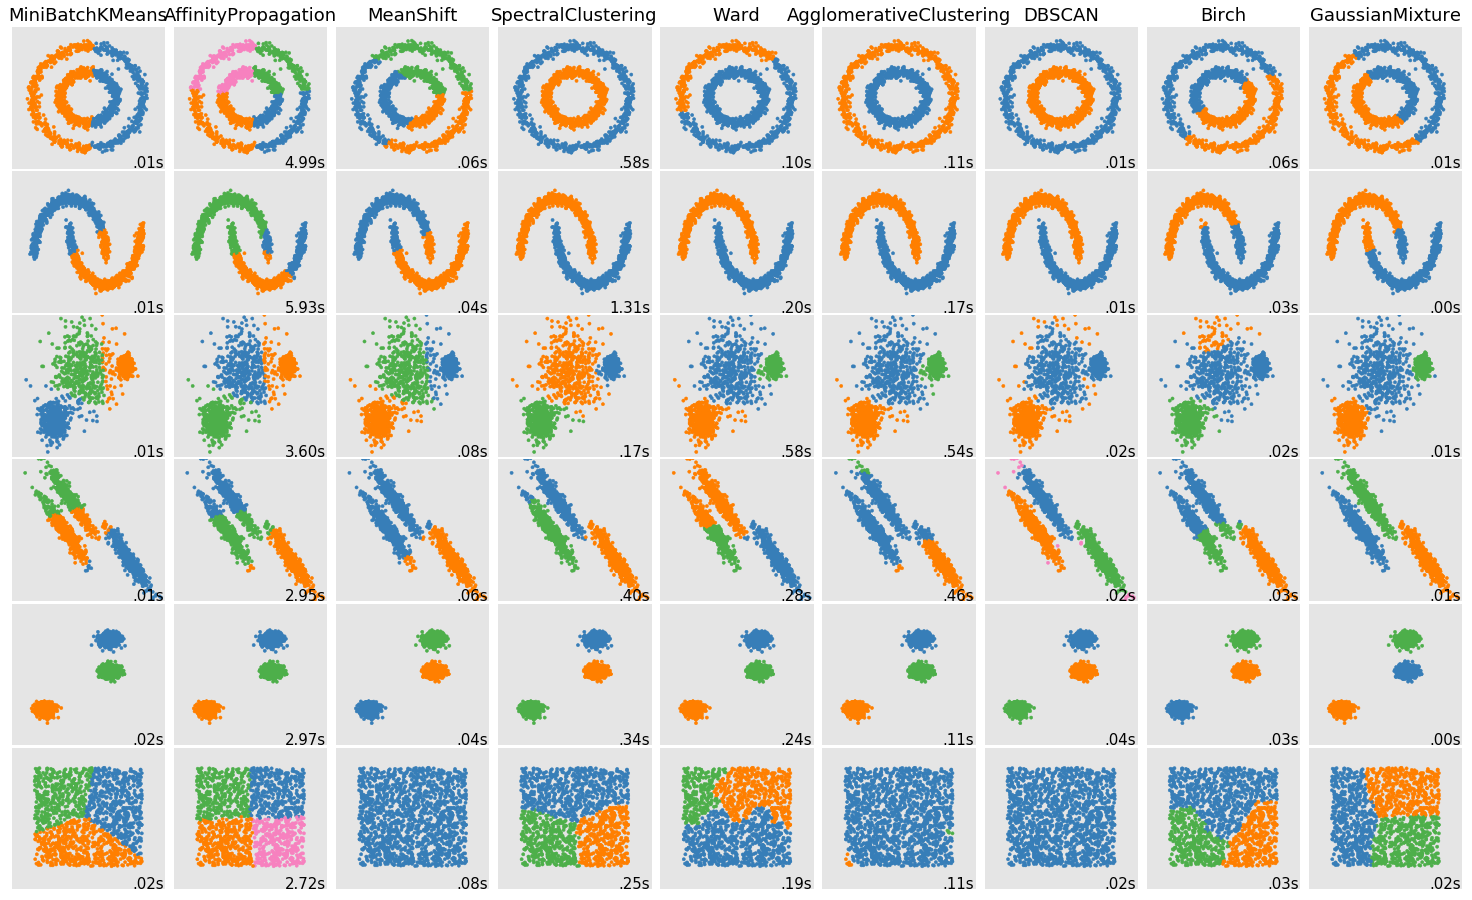

In [23]:
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
plt.style.use("ggplot")
%matplotlib inline

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

list_of_most_active_units = temp.loc[(temp.Status == 'PlugIn')].groupby(['UnitID']).agg({'UnitID' :'count'}).sort_values(['UnitID'], ascending=False).index[1:4].tolist()
tt = temp.loc[(temp.UnitID == list_of_most_active_units[0]) & ((temp.Status == "PlugIn") | (temp.Status == "PlugOut")),:].copy()
one_date_data = tls.make_one_date_date(tt,"index")
one_date_data["ts"] = one_date_data.One_day.astype("int64")
one_date_data.head(n=3)
PlugIn = one_date_data.loc[one_date_data.Status =="PlugIn","ts"].copy().reset_index().ts
PlugOut  =one_date_data.loc[one_date_data.Status =="PlugOut","ts"].copy().reset_index().ts
one = pd.DataFrame({'PlugIn':PlugIn,
                    'PlugOut':PlugOut
                   })
tt = one.as_matrix()


class clustering:
            
    def examples_of_clustering_iris():
        from sklearn import cluster, datasets
        iris = datasets.load_iris()
        X = iris.data#tt.as_matrix()
        y = iris.target

        estimators = [('k_means_iris_8', KMeans(n_clusters=8)),
                      ('k_means_iris_3', KMeans(n_clusters=3)),
                      ('k_means_iris_bad_init', KMeans(n_clusters=3, n_init=1,
                                                       init='random'))]

        fignum = 1
        titles = ['8 clusters', '3 clusters', '3 clusters, bad initialization']
        for name, est in estimators:
            fig = plt.figure(fignum, figsize=(4, 3))
            ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
            est.fit(X)
            labels = est.labels_

            ax.scatter(X[:, 3], X[:, 0], X[:, 2],
                       c=labels.astype(np.float), edgecolor='k')

            ax.w_xaxis.set_ticklabels([])
            ax.w_yaxis.set_ticklabels([])
            ax.w_zaxis.set_ticklabels([])
            ax.set_xlabel('Petal width')
            ax.set_ylabel('Sepal length')
            ax.set_zlabel('Petal length')
            ax.set_title(titles[fignum - 1])
            ax.dist = 12
            fignum = fignum + 1

        # Plot the ground truth
        fig = plt.figure(fignum, figsize=(4, 3))
        ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

        for name, label in [('Setosa', 0),
                            ('Versicolour', 1),
                            ('Virginica', 2)]:
            ax.text3D(X[y == label, 3].mean(),
                      X[y == label, 0].mean(),
                      X[y == label, 2].mean() + 2, name,
                      horizontalalignment='center',
                      bbox=dict(alpha=.2, edgecolor='w', facecolor='w'))
        # Reorder the labels to have colors matching the cluster results
        #y = np.choose(y, [1, 2, 0]).astype(np.float)
        ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y, edgecolor='k')

        ax.w_xaxis.set_ticklabels([])
        ax.w_yaxis.set_ticklabels([])
        ax.w_zaxis.set_ticklabels([])
        ax.set_xlabel('Petal width')
        ax.set_ylabel('Sepal length')
        ax.set_zlabel('Petal length')
        ax.set_title('Ground Truth')
        ax.dist = 12

        fig.show()


    def DBSCAN_model_test_version(df_asmatrix):
        X  = df_asmatrix.as_matrix()
        #X, label = make_moons(n_samples = 200, noise=0.1, random_state =19)
        print( X[:5,])
        model  = DBSCAN(eps = 0.25, min_samples =12).fit(X)
        print(model, model.labels_, model.core_sample_indices_)
        fig, ax = plt.subplots(figsize =(10,8))
        sctr = ax.scatter(X[:,0], X[:,1], c= model.labels_, s=140,alpha=0.9, cmap = plt.cm.Set1)
        
        
    def multipe_clustering_models(temp):
        from sklearn import cluster, datasets, mixture
        from sklearn.neighbors import kneighbors_graph
        from sklearn.preprocessing import StandardScaler
        from itertools import cycle, islice

        print(__doc__)
        np.random.seed(0)
        # ============
        # Generate datasets. We choose the size big enough to see the scalability
        # of the algorithms, but not too big to avoid too long running times
        # ============
        n_samples = 1500
        noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,noise=.05)
        noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
        blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
        no_structure = np.random.rand(n_samples, 2), None

        # Anisotropicly distributed data
        random_state = 170
        X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)

        transformation = [[0.6, -0.6], [-0.4, 0.8]]
        X_aniso = np.dot(X, transformation)
        aniso = (X_aniso, y)

        # blobs with varied variances
        varied = datasets.make_blobs(n_samples=n_samples,
                                     cluster_std=[1.0, 2.5, 0.5],
                                     random_state=random_state)

        # ============
        # Set up cluster parameters
        # ============
        plt.figure(figsize=(9 * 2 + 3, 12.5))
        plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                            hspace=.01)

        plot_num = 1

        default_base = {'quantile': .3,
                        'eps': .3,
                        'damping': .9,
                        'preference': -200,
                        'n_neighbors': 10,
                        'n_clusters': 3}

        datasets = [
            (noisy_circles, {'damping': .77, 'preference': -240,
                             'quantile': .2, 'n_clusters': 2}),
            (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
            (varied, {'eps': .18, 'n_neighbors': 2}),
            (aniso, {'eps': .15, 'n_neighbors': 2}),
            (blobs, {}),
            (no_structure, {})]

        for i_dataset, (dataset, algo_params) in enumerate(datasets):
            # update parameters with dataset-specific values
            params = default_base.copy()
            params.update(algo_params)

            X, y = dataset

            # normalize dataset for easier parameter selection
            X = StandardScaler().fit_transform(X)

            # estimate bandwidth for mean shift
            bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

            # connectivity matrix for structured Ward
            connectivity = kneighbors_graph(
                X, n_neighbors=params['n_neighbors'], include_self=False)
            # make connectivity symmetric
            connectivity = 0.5 * (connectivity + connectivity.T)

            # ============
            # Create cluster objects
            # ============
            ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
            two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
            ward = cluster.AgglomerativeClustering(
                n_clusters=params['n_clusters'], linkage='ward',
                connectivity=connectivity)
            spectral = cluster.SpectralClustering(
                n_clusters=params['n_clusters'], eigen_solver='arpack',
                affinity="nearest_neighbors")
            dbscan = cluster.DBSCAN(eps=params['eps'])
            affinity_propagation = cluster.AffinityPropagation(
                damping=params['damping'], preference=params['preference'])
            average_linkage = cluster.AgglomerativeClustering(
                linkage="average", affinity="cityblock",
                n_clusters=params['n_clusters'], connectivity=connectivity)
            birch = cluster.Birch(n_clusters=params['n_clusters'])
            gmm = mixture.GaussianMixture(
                n_components=params['n_clusters'], covariance_type='full')

            clustering_algorithms = (
                ('MiniBatchKMeans', two_means),
                ('AffinityPropagation', affinity_propagation),
                ('MeanShift', ms),
                ('SpectralClustering', spectral),
                ('Ward', ward),
                ('AgglomerativeClustering', average_linkage),
                ('DBSCAN', dbscan),
                ('Birch', birch),
                ('GaussianMixture', gmm)
            )

            for name, algorithm in clustering_algorithms:
                t0 = time.time()

                # catch warnings related to kneighbors_graph
                with warnings.catch_warnings():
                    warnings.filterwarnings(
                        "ignore",
                        message="the number of connected components of the " +
                        "connectivity matrix is [0-9]{1,2}" +
                        " > 1. Completing it to avoid stopping the tree early.",
                        category=UserWarning)
                    warnings.filterwarnings(
                        "ignore",
                        message="Graph is not fully connected, spectral embedding" +
                        " may not work as expected.",
                        category=UserWarning)
                    algorithm.fit(X)

                t1 = time.time()
                if hasattr(algorithm, 'labels_'):
                    y_pred = algorithm.labels_.astype(np.int)
                else:
                    y_pred = algorithm.predict(X)

                plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
                if i_dataset == 0:
                    plt.title(name, size=18)

                colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                                     '#f781bf', '#a65628', '#984ea3',
                                                     '#999999', '#e41a1c', '#dede00']),
                                              int(max(y_pred) + 1))))
                plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

                plt.xlim(-2.5, 2.5)
                plt.ylim(-2.5, 2.5)
                plt.xticks(())
                plt.yticks(())
                plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                         transform=plt.gca().transAxes, size=15,
                         horizontalalignment='right')
                plot_num += 1

        plt.show()
    #Make matrix out of temp table 
#find unti with the most frequetn charging
    def make_clusters_for_DBSCAN_model_JN_for_the_most_active_users(temp, number_of_avctive_units, eps=4017000000000, min_samples =2):

        list_of_most_active_units = temp.loc[(temp.Status == 'PlugIn')].groupby(['UnitID']).agg({'UnitID' :'count'}).sort_values(['UnitID'], ascending=False).index[1:number_of_avctive_units+1].tolist()

        print("The most active units are:", list_of_most_active_units)
        for item in list_of_most_active_units:
            tt = temp.loc[(temp.UnitID == item) & ((temp.Status == "PlugIn") | (temp.Status == "PlugOut")),:].copy()# & (temp["wd"].isin([1,2,3])),:].copy()
            one_date_data = tls.make_one_date_date(tt,"index")
            one_date_data["ts"] = one_date_data.One_day.astype("int64")
            one_date_data.head(n=3)
            PlugIn = one_date_data.loc[one_date_data.Status =="PlugIn","ts"].copy().reset_index().ts
            PlugOut  =one_date_data.loc[one_date_data.Status =="PlugOut","ts"].copy().reset_index().ts
            one = pd.DataFrame({'PlugIn':PlugIn,
                                'PlugOut':PlugOut
                               })
            one["PInSec"] = (one.PlugIn-pd.to_datetime('1/1/2018')).apply(get_seconds)/60
            one["POutSec"] = (one.PlugOut-pd.to_datetime('1/1/2018')).apply(get_seconds)/60
            print("pp is:", one.head(n=3))
            one["PInSec"]= one["PInSec"].astype("int64")
            one["POutSec"] = one["POutSec"].astype("int64")
            
           
            fg  = one.loc[:,["PInSec","POutSec"]]

            tt = one.as_matrix()
            X  = tt
            #X, label = make_moons(n_samples = 200, noise=0.1, random_state =19)
            print( X[:5,])
            model  = DBSCAN(eps, min_samples).fit(X)
            print(model, model.labels_, model.core_sample_indices_)
            fig, ax = plt.subplots(figsize =(10,8))
            ax.set_xlabel('PlugIn time, min')
            ax.set_ylabel('PlugOut time, min')
            sctr = ax.scatter(X[:,0], X[:,1], c= model.labels_, s=140,alpha=0.9, cmap = plt.cm.Set1)

#clustering.make_clusters_for_DBSCAN_model_JN_for_the_most_active_users(temp,1)
#clustering.examples_of_clustering_iris()
#clustering.DBSCAN_model_test_version(one)
clustering.multipe_clustering_models(one)

In [24]:
temp.head(n=2)

,index,Power,Status,UnitID,wd
0,2017-03-03 14:47:15-08:00,0.000000,PlugIn,0100000100000046495017126501,4
1,2017-03-03 14:47:20-08:00,5.809206,ChargingStart,0100000100000046495017126501,4


In [12]:
clustering.make_clusters_for_DBSCAN_model_JN_for_the_most_active_users(temp,1)

The most active units are: ['0814071459450153393116018968']


TypeError: descriptor '__sub__' requires a 'datetime.datetime' object but received a 'int'

In [13]:
temp.loc[(temp.Status == 'PlugIn')].groupby(['UnitID']).agg({'UnitID' :'count'}).sort_values(['UnitID'], ascending=False)

,UnitID
UnitID,
0814082045261937481216016376,1076
0814071459450153393116018968,663
0100000199990047469017126503,513
81041509461447542020149222,326
0812031330521937482320152880,304
081203130057153552520155646,242
0812031608411535521320153400,241
0814082055581033460517017336,225
0814062324011333502916016450,201


In [13]:
#def DBSCAN_model_JN_for_the_most_active_users_based_ontime_weekdays():
    
from datetime import datetime
def get_seconds(time_delta):
    return time_delta.seconds

list_of_most_active_units = temp.loc[(temp.Status == 'PlugIn')].groupby(['UnitID']).agg({'UnitID' :'count'}).sort_values(['UnitID'], ascending=False).index[1:2].tolist()
tt = temp.loc[(temp.UnitID == list_of_most_active_units[0]) & ((temp.Status == "PlugIn") | (temp.Status == "PlugOut")),:].copy() # & (temp["wd"].isin([1,2,3]))

pt = tools.end_and_start_time_differance_delta(tls, tt,'Status','PlugOut', 'PlugIn', 'index')

pt["PlugIn"] = pt["index"].dt.weekday.astype("str")
pt["PlugOut"] = pt["Shifted_Time"].dt.weekday.astype("str")
pt["gr"] = pt["PlugIn"]+pt["PlugOut"]

NW= pd.DataFrame({"gr":["01","12","23","34"], "cluster":"NW"})
DW= pd.DataFrame({"gr":["00","11","22","33","44"], "cluster":"DW"})
FS= pd.DataFrame({"gr":["45"], "cluster":"FS"})
SM= pd.DataFrame({"gr":["60","56"], "cluster":"SM"})
WD= pd.DataFrame({"gr":["55","66"], "cluster":"WD"})

frames = [NW, DW, FS,SM,WD]
cluster_match = pd.concat(frames)
unique_cahrging = cluster_match.gr.tolist()

#important step to get rid of seesion lasting for more than one day
pt = pt.loc[pt["gr"].isin(unique_cahrging)].copy()

#one_date_data = tls.make_one_date_date(tt,"index")

pt = tls.make_one_date_date(pt,"index","PlugIn").copy()
pt = tls.make_one_date_date(pt,"Shifted_Time","PlugOut")

pp = pd.merge(pt,cluster_match, on = ["gr"]) 


pp["PInSec"] = (pp.PlugIn-pd.to_datetime('1/1/2018')).apply(get_seconds)/60
pp["POutSec"] = (pp.PlugOut-pd.to_datetime('1/1/2018')).apply(get_seconds)/60

pp["PInSec"]= pp["PInSec"].astype("int64")
pp["POutSec"] = pp["POutSec"].astype("int64")

#fg  = pp.loc[pp.cluster == "DW",["PInSec","POutSec"]]



In [29]:
fg.head(n=20)

,PInSec,POutSec
14,253,253
15,253,253
16,255,255
17,262,262
18,267,462
19,149,149
20,152,152
21,153,153
22,154,157
23,158,158


In [15]:
pp.loc[pp.cluster == "SM",:]

,Status,index,Shifted_Time,Shifted_EventString,delta,PlugIn,PlugOut,gr,cluster,PInSec,POutSec
190,PlugIn,2017-03-05 20:34:35-08:00,2017-03-06 12:51:49-08:00,PlugOut,16.287222,2018-01-01 20:34:35,2018-01-01 12:51:49,60,SM,1234,771
191,PlugIn,2017-03-12 21:13:49-07:00,2017-03-13 07:56:12-07:00,PlugOut,10.706389,2018-01-01 21:13:49,2018-01-01 07:56:12,60,SM,1273,476
192,PlugIn,2017-03-19 17:09:00-07:00,2017-03-20 04:15:50-07:00,PlugOut,11.113889,2018-01-01 17:09:00,2018-01-01 04:15:50,60,SM,1029,255
193,PlugIn,2017-04-09 22:48:47-07:00,2017-04-10 04:16:23-07:00,PlugOut,5.460000,2018-01-01 22:48:47,2018-01-01 04:16:23,60,SM,1368,256
194,PlugIn,2017-04-16 21:25:05-07:00,2017-04-17 03:59:27-07:00,PlugOut,6.572778,2018-01-01 21:25:05,2018-01-01 03:59:27,60,SM,1285,239
195,PlugIn,2017-04-23 21:05:32-07:00,2017-04-24 04:13:39-07:00,PlugOut,7.135278,2018-01-01 21:05:32,2018-01-01 04:13:39,60,SM,1265,253
196,PlugIn,2017-05-07 21:35:21-07:00,2017-05-08 07:56:25-07:00,PlugOut,10.351111,2018-01-01 21:35:21,2018-01-01 07:56:25,60,SM,1295,476
197,PlugIn,2017-05-14 19:46:28-07:00,2017-05-15 03:36:55-07:00,PlugOut,7.840833,2018-01-01 19:46:28,2018-01-01 03:36:55,60,SM,1186,216
539,PlugIn,2017-03-18 13:12:36-07:00,2017-03-19 04:11:56-07:00,PlugOut,14.988889,2018-01-01 13:12:36,2018-01-01 04:11:56,56,SM,792,251
540,PlugIn,2017-03-25 04:31:33-07:00,2017-03-26 13:38:29-07:00,PlugOut,9.115556,2018-01-01 04:31:33,2018-01-01 13:38:29,56,SM,271,818


[[1060  474]
 [1130  255]
 [1121  252]
 [1346  251]
 [1142  256]]


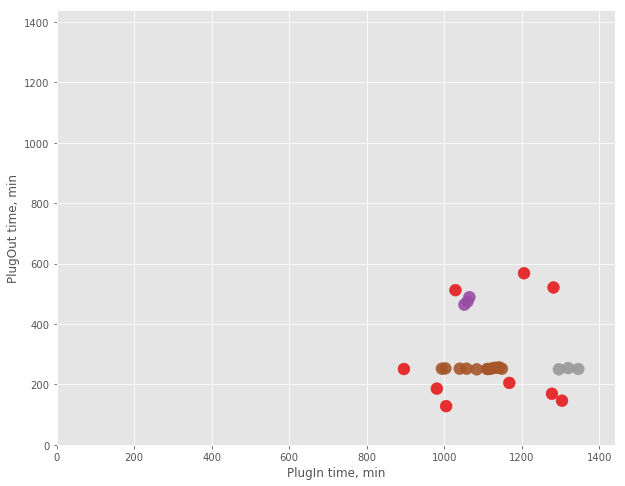

In [16]:

fg  = pp.loc[pp.cluster == "NW",["PInSec","POutSec"]]

X  = fg.as_matrix()
#X, label = make_moons(n_samples = 200, noise=0.1, random_state =19)
print( X[:5,])
model  = DBSCAN(eps = 40, min_samples =3).fit(X)
#print(model, model.labels_, model.core_sample_indices_)
fig, ax = plt.subplots(figsize =(10,8))
ax.set_xlabel('PlugIn time, min')
ax.set_ylabel('PlugOut time, min')
plt.ylim([0, 1440])
plt.xlim([0, 1440])
sctr = ax.scatter(X[:,0], X[:,1], c= model.labels_, s=140,alpha=0.9, cmap = plt.cm.Set1)

In [32]:
fg

,PInSec,POutSec
14,253,253
15,253,253
16,255,255
17,262,262
18,267,462
19,149,149
20,152,152
21,153,153
22,154,157
23,158,158


[[1060  474]
 [1130  255]
 [1121  252]
 [1346  251]
 [1142  256]]


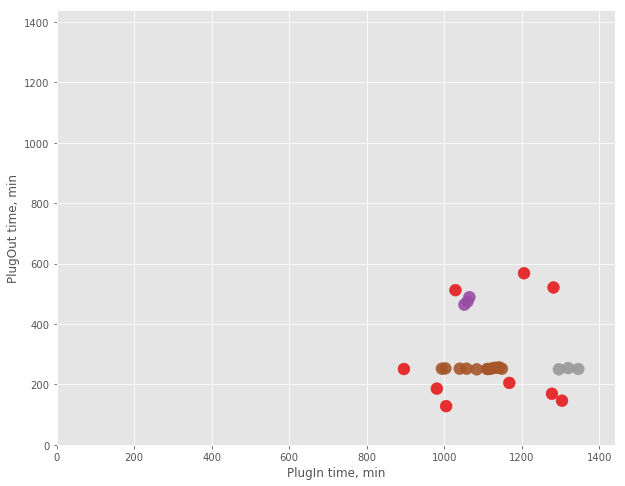

In [17]:

fg  = pp.loc[pp.cluster == "NW",["PInSec","POutSec"]]

X  = fg.as_matrix()
#X, label = make_moons(n_samples = 200, noise=0.1, random_state =19)
print( X[:5,])
model  = DBSCAN(eps = 40, min_samples =3).fit(X)
#print(model, model.labels_, model.core_sample_indices_)
fig, ax = plt.subplots(figsize =(10,8))
ax.set_xlabel('PlugIn time, min')
ax.set_ylabel('PlugOut time, min')
plt.ylim([0, 1440])
plt.xlim([0, 1440])
sctr = ax.scatter(X[:,0], X[:,1], c= model.labels_, s=140,alpha=0.9, cmap = plt.cm.Set1)

[[1119  250]
 [1081  252]
 [1119  252]
 [1081  256]
 [1192  253]]


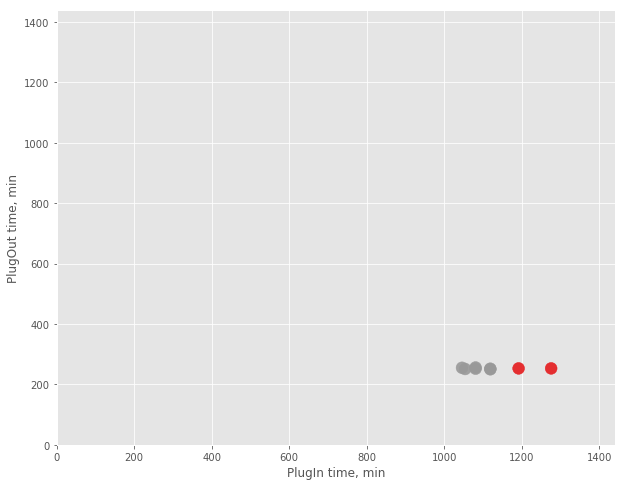

In [18]:

fg  = pp.loc[pp.cluster == "FS",["PInSec","POutSec"]]

X  = fg.as_matrix()
#X, label = make_moons(n_samples = 200, noise=0.1, random_state =19)
print( X[:5,])
model  = DBSCAN(eps = 40, min_samples =3).fit(X)
#print(model, model.labels_, model.core_sample_indices_)
fig, ax = plt.subplots(figsize =(10,8))
ax.set_xlabel('PlugIn time, min')
ax.set_ylabel('PlugOut time, min')
plt.ylim([0, 1440])
plt.xlim([0, 1440])
sctr = ax.scatter(X[:,0], X[:,1], c= model.labels_, s=140,alpha=0.9, cmap = plt.cm.Set1)

[[253 253]
 [253 253]
 [255 255]
 [262 262]
 [267 462]]


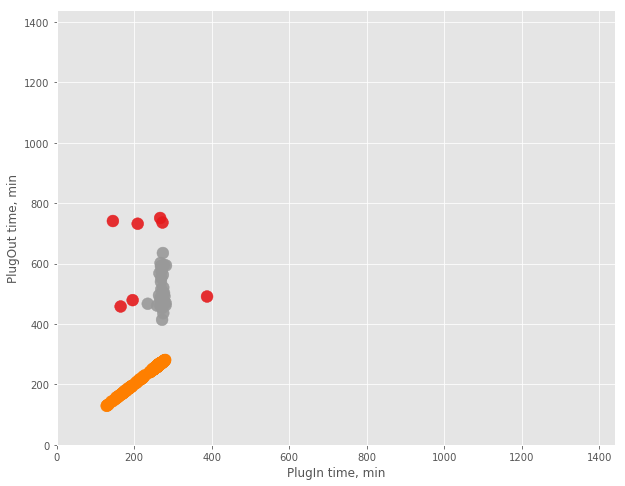

In [19]:

fg  = pp.loc[pp.cluster == "DW",["PInSec","POutSec"]]

X  = fg.as_matrix()
#X, label = make_moons(n_samples = 200, noise=0.1, random_state =19)
print( X[:5,])
model  = DBSCAN(eps = 40, min_samples =3).fit(X)
#print(model, model.labels_, model.core_sample_indices_)
fig, ax = plt.subplots(figsize =(10,8))
ax.set_xlabel('PlugIn time, min')
ax.set_ylabel('PlugOut time, min')
plt.ylim([0, 1440])
plt.xlim([0, 1440])
sctr = ax.scatter(X[:,0], X[:,1], c= model.labels_, s=140,alpha=0.9, cmap = plt.cm.Set1)

In [20]:


def get_seconds(time_delta):
    return time_delta.seconds


from datetime import datetime
list_of_most_active_units = temp.loc[(temp.Status == 'PlugIn')].groupby(['UnitID']).agg({'UnitID' :'count'}).sort_values(['UnitID'], ascending=False).index[1:2].tolist()
tt = temp.loc[(temp.UnitID == list_of_most_active_units[0]) & ((temp.Status == "PlugIn") | (temp.Status == "PlugOut")),:].copy() # & (temp["wd"].isin([1,2,3]))

pt = tools.end_and_start_time_differance_delta(tls, tt,'Status','PlugOut', 'PlugIn', 'index')

pt["PlugIn"] = pt["index"].dt.weekday.astype("str")
pt["PlugOut"] = pt["Shifted_Time"].dt.weekday.astype("str")
pt["gr"] = pt["PlugIn"]+pt["PlugOut"]

NW= pd.DataFrame({"gr":["01","12","23","34"], "cluster":"NW"})
DW= pd.DataFrame({"gr":["00","11","22","33","44"], "cluster":"DW"})
FS= pd.DataFrame({"gr":["45"], "cluster":"FS"})
SM= pd.DataFrame({"gr":["60","56"], "cluster":"SM"})
WD= pd.DataFrame({"gr":["55","66"], "cluster":"WD"})

frames = [NW, DW, FS,SM,WD]
cluster_match = pd.concat(frames)
unique_cahrging = cluster_match.gr.tolist()

#important step to get rid of seesion lasting for more than one day
pt = pt.loc[pt["gr"].isin(unique_cahrging)].copy()

one_date_data = tls.make_one_date_date(tt,"index")



one_date_data["delta"] = (one_date_data.One_day-pd.to_datetime('1/1/2018')).apply(get_seconds)/60
one_date_data["ts"] = one_date_data.One_day.astype("int64")
one_date_data.head(n=3)
PlugIn = one_date_data.loc[one_date_data.Status =="PlugIn","delta"].copy().reset_index().delta
PlugOut  =one_date_data.loc[one_date_data.Status =="PlugOut","delta"].copy().reset_index().delta
#PlugIn = one_date_data.loc[one_date_data.Status =="PlugIn","ts"].copy().reset_index().ts
#PlugOut  =one_date_data.loc[one_date_data.Status =="PlugOut","ts"].copy().reset_index().ts
one = pd.DataFrame({'PlugIn':PlugIn,
                    'PlugOut':PlugOut
                   })
#tt = one.as_matrix().astype(int)

[[ 1060.95         474.78333333]
 [ 1149.35         252.25      ]
 [  253.01666667   253.08333333]
 [  253.83333333   253.9       ]
 [  255.51666667   255.58333333]]


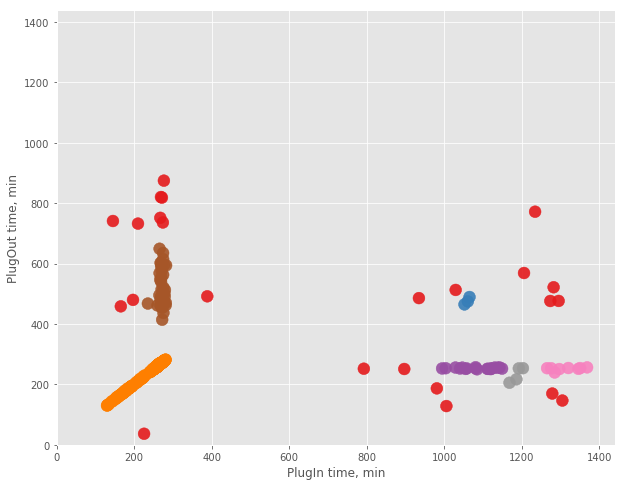

In [21]:
X  = one.as_matrix()
#X, label = make_moons(n_samples = 200, noise=0.1, random_state =19)
print( X[:5,])
model  = DBSCAN(eps = 40, min_samples =3).fit(X)
#print(model, model.labels_, model.core_sample_indices_)
fig, ax = plt.subplots(figsize =(10,8))
ax.set_xlabel('PlugIn time, min')
ax.set_ylabel('PlugOut time, min')
plt.ylim([0, 1440])
plt.xlim([0, 1440])
sctr = ax.scatter(X[:,0], X[:,1], c= model.labels_, s=140,alpha=0.9, cmap = plt.cm.Set1)

In [661]:
from sklearn import cluster, datasets
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target

k_means = cluster.KMeans(n_clusters=3)
k_means.fit(X_iris) 

print(k_means.labels_[::10])

print(y_iris[::10])

[0 0 0 0 0 2 2 2 2 2 1 1 1 1 1]
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]


# ChargingStart values 

In [ ]:
vvv.loc[(vvv.EventString == 'ChargingStop') & (vvv.EventDuration != vvv.ChargingTime), 'snum' ].shape

In [ ]:
vvv.loc[(vvv.EventString == 'ChargingStop') & (vvv.EventDuration != vvv.ChargingTime), : ]

In [ ]:
templist = kk.loc[(kk.EventDuration != kk.ChargingTime),'snum'].unique()
templist

In [ ]:
gg = pd.concat([d,line_two,rt],axis=1).loc[:,['RowKey','Timestamp','UnitID','EventString','two','EventEnergy','Time','day','month','ndUnitId']]

## Abrupted sesions on the same Unit ID

In [ ]:
gg.loc[(gg.EventString == 'ChargingStop') & (gg.two == 'ChargingStop') & (gg.UnitID == gg.ndUnitId),:].shape

In [ ]:
gg.loc[(gg.EventString == 'ChargingStop') & (gg.two == 'ChargingStop') & (gg.UnitID == gg.ndUnitId),:].head(n=20)

## Abrupted sesions on the different Unit ID

In [ ]:
gg.loc[(gg.EventString == 'ChargingStop') & (gg.two == 'ChargingStop') & (gg.UnitID != gg.ndUnitId),:].shape

In [ ]:
gg.loc[(gg.EventString == 'ChargingStop') & (gg.two == 'ChargingStop') & (gg.UnitID != gg.ndUnitId),:].head(n=1)

In [ ]:
import pandas as pd
import numpy as np
exam_data = [{'name':'Anastasia', 'score':12.5}, {'name':'Dima','score':9}, {'name':'Katherine','score':16.5}]
cc = pd.DataFrame(exam_data)
for index, row in cc.iterrows():
    print(row[1], row[0], index)

In [ ]:
test_set = pd.DataFrame(tf.iloc[0:4,:])

In [ ]:

for index, row in test_set.iterrows():
    tr = pd.DataFrame(np.arange(row[9],row[9]-row[6],-300).astype('int').astype('str'))
    sample = tr 
    print(sample)

In [ ]:
for i in range(0,2):
    tr = pd.DataFrame(np.arange(1488591907,1488591907-10668.0,-300).astype('int').astype('str'))
    tf.iloc[:,tf.shape[1]-1:tf.shape[1]].head(n=2)
    
    print(tf.iloc[i])

In [ ]:
pd.DataFrame(np.arange(1488591907,1488591907-10668.0,-300).astype('int').astype('str'))